In [77]:
%pip install -q langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python 'nomic[local]' langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.


In [78]:
import os

import json 
with open('/Users/kaustuv/Desktop/AI_projects/config.json') as f:
    config = json.load(f) 
    os.environ['LANGCHAIN_API_KEY'] = config['LANGCHAIN_API_KEY']
    os.environ["TAVILY_API_KEY"] = config['TAVILY_API_KEY']

os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'


### Build a Basic Chatbot

In [79]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
    user_message: str


state_graph = StateGraph(State)

In [80]:
### Generate

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama


# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an chatbot for question-answering tasks. 
    If you need you can use the following chat history to answer the question. If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
    User message: {user_message} 
    Message history: {chat_history} 
    Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["user_message", "chat_history"],
)

local_llm = "llama3.1"
llm = ChatOllama(model=local_llm, 
                 temperature=0)


# # Post-processing
# def format_docs(docs):
#     return "\n\n".join(doc.page_content for doc in docs)


# Chain
chatbot_llm = prompt | llm | StrOutputParser()

# # Run
# history = "jupiter is the largest planet in the solar system"
# message = "how many moons does it have"
# generation = chatbot_llm.invoke({"chat_history": history, "user_message": message})
# print(generation)

In [81]:

from langchain_community.chat_models import ChatOllama
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage
from langgraph.graph import END, StateGraph, MessagesState



memory = MemorySaver()

# # LLM
local_llm = "llama3.1"
llm = ChatOllama(model=local_llm, 
                 temperature=0)

# Nodes
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Create graph
state_graph.add_node("chatbot", call_model)

state_graph.add_edge(START, "chatbot")
state_graph.add_edge("chatbot", END)

# Notice we're using an in-memory checkpointer. This is convenient for our tutorial (it saves it all in-memory). 
# In a production application, you would likely change this to use SqliteSaver or PostgresSaver and connect to your own DB.
memory = MemorySaver()
graph = state_graph.compile(checkpointer=memory)

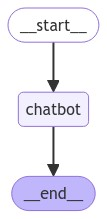

In [82]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass



In [83]:
config = {"configurable": {"thread_id": "2"}}

while True:

    user_input = input("User: ")
    # print('\nUser:', user_input)

    if user_input.lower() in ["quit", "exit", "q"]:
        break

    events = graph.invoke(
        {"messages": [HumanMessage(content=user_input)]}, config, stream_mode="values"
    )
    print(events["messages"][-1].pretty_print())

================================== Ai Message ==================================

The tallest mountain in the world is Mount Everest, located in the Himalayas on the border between Nepal and Tibet, China. It stands at an incredible:

**8,848 meters (29,029 feet) above sea level**

Mount Everest was formed when the Indian tectonic plate collided with the Eurasian plate, pushing up the Earth's crust to create the highest mountain peak in the world.

Did you know that Mount Everest is still growing taller by about 1 inch (2.5 cm) every year due to the ongoing collision of these two plates?
None
================================== Ai Message ==================================

Mount Everest, the tallest mountain in the world, is located in the Himalayas on the border between:

**Nepal and Tibet, China**

To be more specific, its location is:

* **Latitude:** 27.98805° N
* **Longitude:** 86.92502° E
* **Country:** Nepal (southern part) and Tibet Autonomous Region, China (northern part)

The 